In [12]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from textwrap import fill

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

In [13]:
#Make Simulator and Training Data
cs_name_val = 16
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(15, 15, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
# print(sim_data.theta_vals)
all_gp_data = sim_data
all_val_data = val_data

0.007518970786230407


In [14]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel

#Get GP object
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Train on all sets
train_data, test_data = gp_object.set_train_test_data(0.8, seed)
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp(new_gp_model)
hps_org = gp_object.trained_hyperparams
# hps_trained = hps_org[0].tolist() + hps_org[1:]

In [15]:
#Create a Data Class which is Sim and Val Data together
t_train_val = np.concatenate((sim_data.theta_vals, val_data.theta_vals))
x_train_val = np.concatenate((sim_data.x_vals, val_data.x_vals))
y_train_val = np.concatenate((sim_data.y_vals, val_data.y_vals))

all_data = Data(t_train_val, x_train_val, y_train_val, None, None, None, None, None, 
all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

X = gp_object.featurize_data(all_data)
y = all_data.y_vals

In [16]:
#Create a Data Class which is Sim and Val Data together
t_train_val = np.concatenate((sim_data.theta_vals, val_data.theta_vals))
x_train_val = np.concatenate((sim_data.x_vals, val_data.x_vals))
y_train_val = np.concatenate((sim_data.y_vals, val_data.y_vals))

all_data = Data(t_train_val, x_train_val, y_train_val, None, None, None, None, None, 
all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

X = gp_object.featurize_data(all_data)
y = all_data.y_vals
n_samples = len(all_data.y_vals)

predict_mean = []
predict_std = []
train_mean = []
train_std = []


#For each sample in the full set
for i in range(n_samples):
    #Get sample Data
    t_leave_one = np.atleast_2d(all_data.theta_vals[i])
    X_leave_one = np.atleast_2d(all_data.x_vals[i])
    y_leave_one = np.atleast_1d(all_data.y_vals[i])
    t_rest = np.delete(all_data.theta_vals,i,axis=0)
    X_rest = np.delete(all_data.x_vals,i,axis=0)
    y_rest = np.delete(all_data.y_vals,i,axis=0)
    loo_data = Data(t_leave_one, X_leave_one, y_leave_one, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    loo_data_train = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    #Create GP object based on the above
    gp_new = Type_2_GP_Emulator(loo_data_train, loo_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                1, seed, normalize, None, None, None, None)
    gp_new.scalerX = gp_object.scalerX
    gp_new.scalerY = gp_object.scalerY
    #Create GP Model Based On Past Hyperparamaters
    loo_ft = gp_new.featurize_data(loo_data)
    loo_ft_trn = gp_new.featurize_data(loo_data_train)
    noise_kern = WhiteKernel(noise_level= hps_org[1], noise_level_bounds= "fixed")
    cont_kern = ConstantKernel(constant_value = hps_org[-1], constant_value_bounds="fixed")
    kernel = cont_kern*Matern(length_scale = hps_org[0], length_scale_bounds="fixed", nu=2.5) + noise_kern
    gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=gp_new.retrain_GP, 
                                            random_state = gp_new.seed, optimizer = None, normalize_y = not gp_new.normalize)
    gp_new.fit_gp_model = gp_model.fit(loo_ft_trn, y_rest.reshape(-1,1))

    #Predict With New model
    y_loo_mean, y_loo_var = gp_new.eval_gp_mean_var_misc(loo_data, loo_ft, covar = False)
    y_loo_std =  np.sqrt(y_loo_var)

    #Check for feat_loo in train and test feat
    is_row_train = np.any(np.all(gp_object.feature_train_data == loo_ft, axis=1))
    if is_row_train:
        train_mean.append(float(y_loo_mean))
        train_std.append(float(y_loo_std))
    else:
        predict_mean.append(float(y_loo_mean))
        predict_std.append(float(y_loo_std))

In [17]:
R2_score = r2_score(val_data.y_vals, predict_mean)
print(predict_mean)
print(predict_std)
print(R2_score)

[0.5449492029338189, 0.007083444390032834, -0.029369687446364534, 0.12560788589389554, 0.7690104634055738, 0.31362714962755933, 0.1625986251698124, 0.16610391846513178, 0.2989378183401256, 0.6601927189197715, 0.11693304617549212, 0.8097228228211881, -0.2542867169070061, -0.07144211209446066, 0.8935497453306281, 0.5878346653086362, 0.451945388892384, 0.5256437290563253, 0.6929471234900123, 0.7621427738081169, 0.75433988275695, 0.4310259336951261, 0.342767123029155, 0.6654694713942266, 0.4249441771509085, 0.6458578807990405, 0.7507260023466191, 0.5223826990075785, 0.4458789393029333, 0.5036951015125221, 0.6014576442905304, 0.37430032528186413, 0.8074440449746354, 0.5583649778264227, 0.8496041901116211, 0.6247118935797056, 0.30067654839377383, 0.23140147944398187, 0.5205026321006072, 0.5741530510180392, 0.4823444489502605, 0.9958031813486802, 0.7105454793825303, 0.40501914998001587, 0.9824079009726727, 0.0494026110904105, 0.15002932518563514, 0.6811333999046028, 0.0697508349937012, 0.1318

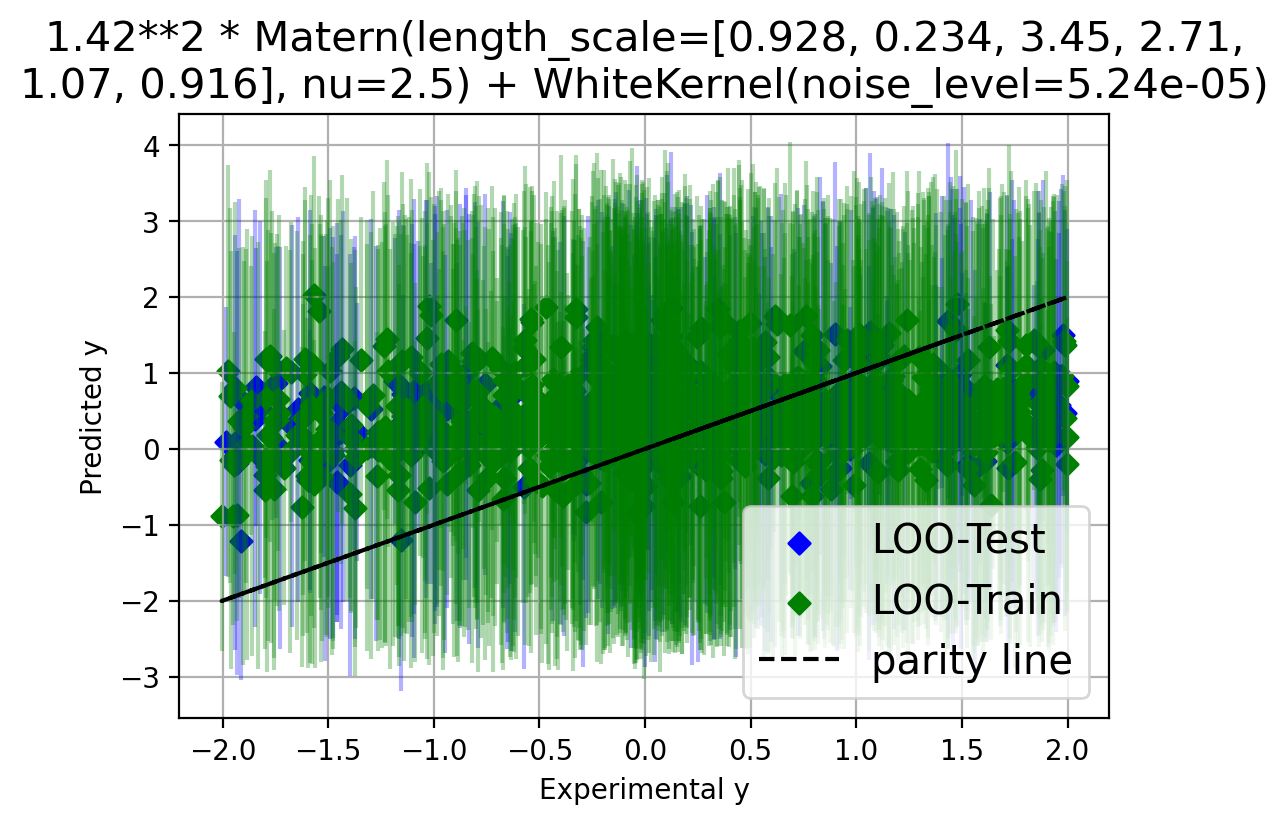

In [18]:
text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))

plt.scatter(val_data.y_vals, predict_mean, 30,c='b', marker='D', label='LOO-Test')
plt.errorbar(val_data.y_vals, predict_mean, 1.96*np.array(predict_std), c='b', fmt = ' ', alpha = 0.3)
plt.scatter(sim_data.y_vals, train_mean, 30,c='g', marker='D', label='LOO-Train')
plt.errorbar(sim_data.y_vals, train_mean, 1.96*np.array(train_std), c='g', fmt = ' ', alpha = 0.3)

plt.plot(y,y,'k--', label='parity line')
plt.xlabel('Experimental y')
plt.ylabel('Predicted y')
plt.title(fill(str(gp_object.fit_gp_model.kernel_), 60), fontdict={'size':15})
plt.grid(True)
plt.legend(fontsize='x-large')
# plt.text(1500, 100, text)
# plt.text(1000, 0, '*Error Bars are 1.96 Standard Deviation')
# plt.savefig('pic_Loo_R2_score')
plt.show()